The following notebook adapts some code from the TensorFlow tutorial: https://www.tensorflow.org/tutorials/keras/classification

In [1]:
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

C:\Users\Josh\Anaconda2\envs\MLCW\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Josh\Anaconda2\envs\MLCW\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Josh\Anaconda2\envs\MLCW\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Josh\Anaconda2\envs\MLCW\lib\site-packages\tensorflow\python\framework

## Import MNIST

In [2]:
fashion_mnist = keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

In [3]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [4]:
train_images.shape

(60000, 28, 28)

In [6]:
test_images.shape

(10000, 28, 28)

In [5]:
train_labels

array([9, 0, 0, ..., 3, 0, 5], dtype=uint8)

## Preprocess Images

In [7]:
# scale pixels to 0-1
train_images = train_images / 255.0
test_images = test_images / 255.0

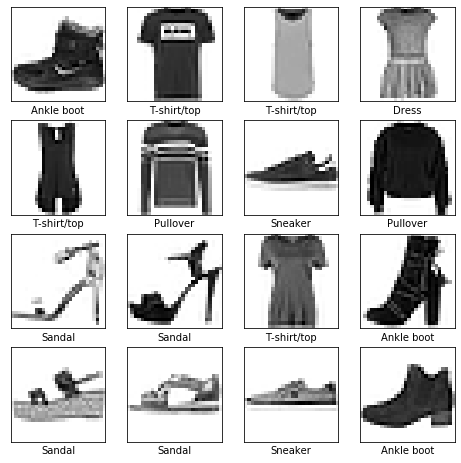

In [13]:
plt.figure(figsize=(8,8))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()

## Build Adam Model

TODO: Find a way to optimise these layers (will be needed for report)

In [9]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(128, activation='relu'),  # dense = fully-connected
    keras.layers.Dense(10)
])

Instructions for updating:
Colocations handled automatically by placer.


TODO: This is the point where we can add the following:
* Loss function
* Optimiser (i.e. the WAME algorithm)
* Metrics - used in metrics e.g accuracy

In [11]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Instructions for updating:
Use tf.cast instead.


### Train

In [14]:
model.fit(train_images, train_labels, epochs=10)

Epoch 1/10
60000/60000 [==============================] - 4s 72us/sample - loss: 0.4987 - acc: 0.1055
Epoch 2/10
60000/60000 [==============================] - 4s 72us/sample - loss: 0.3764 - acc: 0.1027
Epoch 3/10
60000/60000 [==============================] - 4s 75us/sample - loss: 0.3378 - acc: 0.1029
Epoch 4/10
60000/60000 [==============================] - 4s 67us/sample - loss: 0.3163 - acc: 0.1043
Epoch 5/10
60000/60000 [==============================] - 5s 85us/sample - loss: 0.2984 - acc: 0.1024
Epoch 6/10
60000/60000 [==============================] - 4s 70us/sample - loss: 0.2824 - acc: 0.1033
Epoch 7/10
60000/60000 [==============================] - 4s 61us/sample - loss: 0.2731 - acc: 0.1025
Epoch 8/10
60000/60000 [==============================] - 4s 65us/sample - loss: 0.2632 - acc: 0.1024
Epoch 9/10
60000/60000 [==============================] - 4s 62us/sample - loss: 0.2506 - acc: 0.1023
Epoch 10/10
60000/60000 [==============================] - 4s 62us/sample - loss: 

In [15]:
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

print('\nTest accuracy:', test_acc)

 - 0s - loss: 0.3457 - acc: 0.0862

Test accuracy: 0.0862
